<a href="https://colab.research.google.com/github/denisecammarota/d2ai-notes/blob/main/ch5_d2ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F

## Loading and preparing data

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
X_train = df_train.drop(columns = ['Id', 'SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns = ['Id'])

X_train = pd.get_dummies(X_train)
X_train = X_train.fillna(0)

In [ ]:
X_train = df_train.drop(columns = ['Id', 'SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns = ['Id'])

X_train = pd.get_dummies(X_train)
X_train = X_train.fillna(0)

X_test = pd.get_dummies(X_test)
X_test = X_test.fillna(0)
X_test = X_test.reindex(columns = X_train.columns, fill_value = 0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype = torch.float32), torch.tensor(y_train, dtype = torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype = torch.float32))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

## Linear Regression

### Defining model

In [ ]:
class LinearRegression(nn.Module):

  def __init__(self):
      super().__init__()
      self.linear = nn.LazyLinear(out_features = 1)

  def forward(self, x):
    return self.linear(x)

### Implementing the desired loss function

In [ ]:
class RMSLog(nn.Module):

  def __init__(self, eps = 1e-7):
    super().__init__()
    self.eps = eps

  def forward(self, y_pred, y_true):

    y_pred = torch.clamp(y_pred, min = self.eps)
    y_true = torch.clamp(y_true, min = self.eps)

    log_pred = torch.log(y_pred + 1)
    log_true = torch.log(y_true + 1)

    return torch.sqrt(torch.mean((log_pred - log_true)**2))


### Training

In [ ]:
model = LinearRegression()
criterion = RMSLog()
optimizer = optim.SGD(model.parameters(), lr = 0.5)

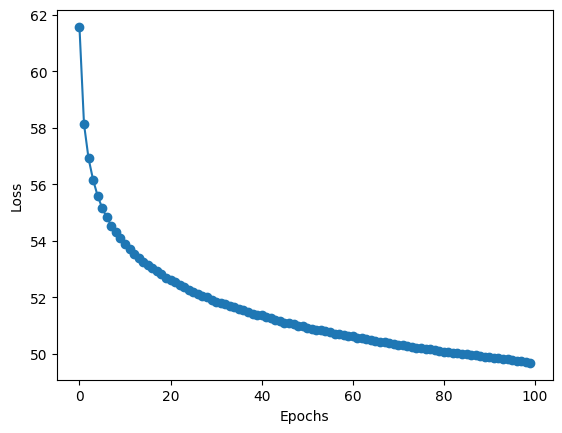

In [ ]:
n_epochs = 100
train_loss = []

for epoch in range(n_epochs):
  train_aux = 0
  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    y_pred = torch.clamp(output, min=1e-7)
    y_true = torch.clamp(batch_y, min=1e-7)
    train_aux += ((torch.log1p(y_pred) - torch.log1p(y_true)) ** 2).sum().item() # because not linear
  train_loss.append(np.sqrt(train_aux/len(train_dataset))) # / number of training dataset

plt.plot(range(n_epochs), train_loss, '-o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Making predictions and plotting

In [ ]:
model.eval()
train_loader_eval = DataLoader(train_dataset, batch_size = 64, shuffle=False)
train_pred = []
with torch.no_grad():
  for batch_X, batch_y in train_loader_eval:
    output = model(batch_X)
    train_pred.append(output)
train_pred = torch.cat(train_pred, dim=0)

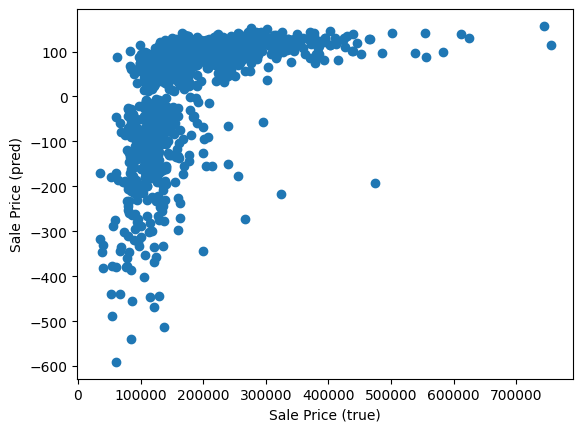

In [ ]:
plt.plot(df_train['SalePrice'], train_pred, 'o')
plt.xlabel('Sale Price (true)')
plt.ylabel('Sale Price (pred)')
plt.show()

### Model parameters

In [ ]:
weights = model.linear.weight.data
print("Weights:", weights) #there are negative weights, hence possible negative predictions

Weights: tensor([[-2.5154e+00,  3.9545e-01,  1.3507e+00,  1.5241e+00,  4.3524e-01,
          5.5905e+00,  1.4036e+00,  2.8565e-01,  1.1960e+00,  5.3218e-01,
         -1.0094e+00,  4.8842e-01,  1.4263e+00, -8.2799e-01, -2.7246e+00,
          1.5447e-01,  2.1344e+00,  1.5983e+00,  1.1153e+00,  5.3646e-01,
          6.1691e-01, -2.1503e+00, -6.1612e-01,  2.2678e+00,  8.9772e+00,
          4.1754e+00,  4.6972e+00, -5.2926e-02,  3.7688e-01, -7.5448e-01,
         -1.6989e-01,  4.0805e-01,  7.3940e-01, -5.2054e-02, -6.5376e-01,
          3.8713e-01, -3.1366e+00,  2.3658e+00, -1.2271e+00,  7.8130e+00,
         -9.3127e+00, -1.2594e+00,  1.2792e+00, -3.9203e+00,  9.5690e-01,
          1.0549e+00, -1.6238e-01, -1.8882e-01, -8.4538e-01, -1.6973e+00,
          1.1014e+00,  1.5050e-01,  4.3395e-01, -1.0986e-02, -6.1772e-02,
          3.9624e-02,  2.3627e-02,  7.0742e-01, -4.5448e-02, -2.1030e-01,
         -5.7750e-01,  5.1817e-01,  2.1308e-01,  2.6549e-01, -1.4222e+00,
         -3.9575e+00, -6.1901

In [ ]:
bias = model.linear.bias.data
print("Bias:", bias)

Bias: tensor([37.7096])


## MLP model

In [ ]:
class MLPRegression(nn.Module):

  def __init__(self, dim_hidden):
      super().__init__()
      activation = nn.ReLU
      self.mlp = nn.Sequential(nn.LazyLinear(out_features = dim_hidden),
                               activation(),
                               nn.LazyLinear(out_features = 1))

  def forward(self, x):
    return self.mlp(x)

In [ ]:
model = MLPRegression(dim_hidden = 10)
criterion = RMSLog()
optimizer = optim.SGD(model.parameters(), lr = 0.5)

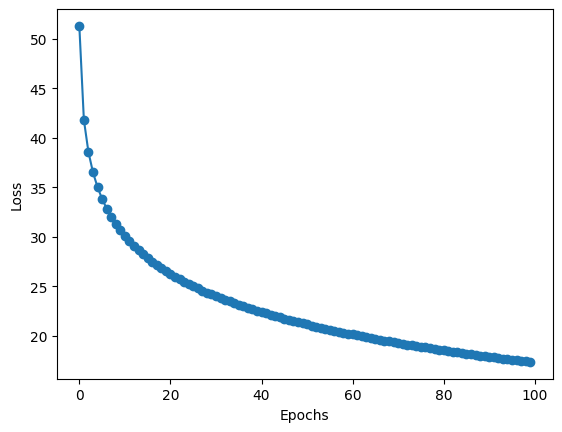

In [ ]:
n_epochs = 100
train_loss = []

for epoch in range(n_epochs):
  train_aux = 0
  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    y_pred = torch.clamp(output, min=1e-7)
    y_true = torch.clamp(batch_y, min=1e-7)
    train_aux += ((torch.log1p(y_pred) - torch.log1p(y_true)) ** 2).sum().item() # because not linear
  train_loss.append(np.sqrt(train_aux/len(train_dataset))) # / number of training dataset

plt.plot(range(n_epochs), train_loss, '-o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.eval()
train_loader_eval = DataLoader(train_dataset, batch_size = 64, shuffle=False)
train_pred = []
with torch.no_grad():
  for batch_X, batch_y in train_loader_eval:
    output = model(batch_X)
    train_pred.append(output)
train_pred = torch.cat(train_pred, dim=0)

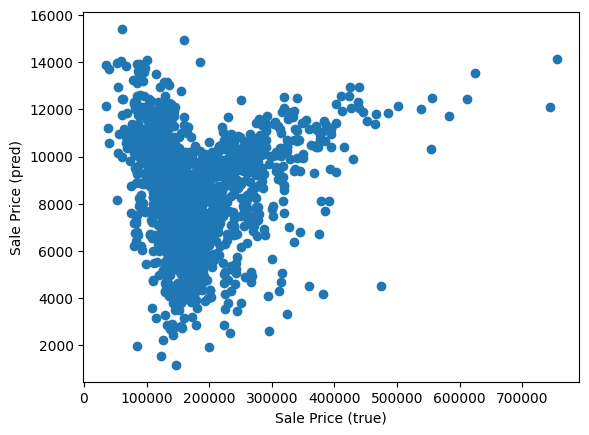

In [ ]:
plt.plot(df_train['SalePrice'], train_pred, 'o')
plt.xlabel('Sale Price (true)')
plt.ylabel('Sale Price (pred)')
plt.show()